# data analysis and wrangling


## Imports

In [544]:
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import ppscore as pps

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier


## Load Data

In [545]:
train_df = pd.read_csv('../dataset/train.csv')
test_df = pd.read_csv('../dataset/test.csv')
print(train_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


In [546]:
all_df = pd.concat((train_df.loc[:,'Pclass':'Embarked'], test_df.loc[:,'Pclass':'Embarked'])).reset_index(drop=True)

In [547]:
all_df['Title'] = all_df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
pd.crosstab(all_df['Title'], all_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,4
Countess,1,0
Don,0,1
Dona,1,0
Dr,1,7
Jonkheer,0,1
Lady,1,0
Major,0,2


In [548]:
all_df['Title'] = all_df['Title'].replace(['Mlle', 'Lady', 'Ms', 'Countess'], 'Miss')
all_df['Title'] = all_df['Title'].replace('Mme', 'Mrs')
all_df['Title'] = all_df['Title'].replace(['Sir', 'Major'], 'Mr')
all_df['Title'] = all_df['Title'].replace('^(?!.*(Miss|Mrs|Mr|Master)).*$', 'Rare',regex=True)

In [549]:
title_mapping = {"Mr": 1, "Miss": 4, "Mrs": 2, "Master": 3, "Rare": 0}

all_df['Title'] = all_df['Title'].map(title_mapping)
all_df['Title'] = all_df['Title'].fillna(0)

all_df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,4
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


In [550]:
arr = all_df.pivot_table(index=['Ticket'], aggfunc='size')
for x in arr.index:
     all_df.loc[ all_df['Ticket'] == x, 'Mu1'] = arr.get(x)
    
all_df = all_df.drop(['Ticket'], axis=1)
# all_df.head()

In [551]:
all_df = all_df.drop(['Name'], axis=1)

In [552]:
all_df['Sex'] = all_df['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
all_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Mu1
0,3,0,22.0,1,0,7.2500,NaN,S,1,1.0
1,1,1,38.0,1,0,71.2833,C85,C,2,2.0
2,3,1,26.0,0,0,7.9250,NaN,S,4,1.0
3,1,1,35.0,1,0,53.1000,C123,S,2,2.0
4,3,0,35.0,0,0,8.0500,NaN,S,1,1.0


## Completing a numerical continuous feature¶


In [553]:
# grid = sns.FacetGrid(train_df, row='Title', col='Sex', size=2.2, aspect=1.6)
# grid.map(plt.hist, 'Age', alpha=.5, bins=20)
# grid.add_legend()

In [554]:
guess_ages = np.zeros((2,5))
guess_ages

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [555]:

for i in range(0,2):
    for j in range(0,5):
        guss_df = all_df[(all_df['Sex'] == i) & (all_df['Title'] == j )]['Age'].dropna()
        guss_age = guss_df.median()
        if guss_age != guss_age:
            guss_age = -5 #dataset[(dataset['Sex'] == i)]['Age'].dropna().median()
        guess_ages[i,j] = int(guss_age/0.5 + 0.5) * 0.5
for i in range(0,2):
    for j in range(0,5):
        all_df.loc[(all_df.Age.isnull()) & (all_df.Sex == i ) & ( all_df.Title == j), 'Age'] = guess_ages[i,j]

# all_df.loc[(all_df.Age.isnull()), 'Age'] = all_df[(all_df['Sex'] == i)]['Age'].dropna().median()           
all_df['Age'] = all_df['Age'].astype(int)
all_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Mu1
0,3,0,22,1,0,7.2500,NaN,S,1,1.0
1,1,1,38,1,0,71.2833,C85,C,2,2.0
2,3,1,26,0,0,7.9250,NaN,S,4,1.0
3,1,1,35,1,0,53.1000,C123,S,2,2.0
4,3,0,35,0,0,8.0500,NaN,S,1,1.0


In [556]:
all_df.loc[ (all_df['Title'] == 0) & (all_df['Age'] <= 18)& (all_df['Sex'] <= 0), 'Title'] = 3
all_df.loc[ (all_df['Title'] == 0) & (all_df['Age'] <= 18)& (all_df['Sex'] <= 1), 'Title'] = 4
all_df.loc[ (all_df['Title'] == 0) & (all_df['Age'] > 18)& (all_df['Sex'] <= 1), 'Title'] = 2
all_df.loc[ (all_df['Title'] == 0) & (all_df['Age'] > 18)& (all_df['Sex'] <= 0), 'Title'] = 1

# all_df.head()

In [557]:
cabin_category = {'A':9, 'B':8, 'C':7, 'D':6, 'E':5, 'F':4, 'G':3, 'T':2}

# all_df['Cabin'] = all_df['Cabin'].fillna('U')
all_df['Cabin'] = all_df['Cabin'].replace('([0-9]+)', '',regex=True).str.slice(0, 1)
all_df['Cabin'] = all_df['Cabin'].map(cabin_category)
    
# all_df = all_df.drop(['Cabin'], axis=1)

In [558]:
freq_port = train_df.Embarked.dropna().mode()[0]
all_df['Embarked'] = all_df['Embarked'].fillna(freq_port)
all_df['Embarked'] = all_df['Embarked'].map( {'S': 0, 'C': 2, 'Q': 1} ).astype(int)

all_df['Pclass'] = all_df['Pclass'].fillna(freq_port)
all_df['Pclass'] = all_df['Pclass'].map( {3: 0, 2: 1, 1: 2} ).astype(int)

In [559]:
guess_cabins = np.zeros((3,3))
for i in range(0,3):
    for j in range(0,3):
        guess_df = all_df[(all_df['Pclass'] == i) & (all_df['Embarked'] == j)]['Cabin'].dropna()
        guess_cabin = guess_df.median()
        # if guss_age != guss_age:
        #     guss_age = -5 #dataset[(dataset['Sex'] == i)]['Age'].dropna().median()
        guess_cabins[i,j] = int(guess_cabin/0.5 + 0.5) * 0.5
for i in range(0,3):
    for j in range(0,3):
        all_df.loc[(all_df.Cabin.isnull()) & (all_df.Pclass == i ) & ( all_df.Embarked == j), 'Cabin'] = guess_cabins[i,j]

In [560]:
# train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
# train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

In [561]:
# for dataset in combine:    
#     dataset.loc[ dataset['Age'] <= 16, 'Age'] = 4
#     dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 3
#     dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
#     dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 1
#     dataset.loc[ dataset['Age'] > 64, 'Age'] = 0
# train_df.head()

In [562]:
# train_df = train_df.drop(['AgeBand'], axis=1)
# combine = [train_df, test_df]
# train_df.head()

In [563]:
all_df['FamilySize'] = all_df['SibSp'] + all_df['Parch'] + 1

# train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

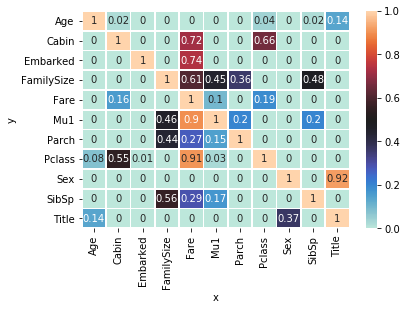

In [564]:
matrix_pps = pps.matrix(all_df)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
matrix_pps = matrix_pps.apply(lambda x: round(x, 2))

sns.heatmap(matrix_pps, vmin=0, vmax=1, cmap="icefire", linewidths=0.75, annot=True)

In [565]:
# for dataset in combine:
#     dataset['IsAlone'] = 0
#     dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

# train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

In [566]:
all_df = all_df.drop(['Parch', 'SibSp'], axis=1)
all_df.head()

,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,Mu1,FamilySize
0,0,0,22,7.2500,4.0,0,1,1.0,2
1,2,1,38,71.2833,7.0,2,2,2.0,2
2,0,1,26,7.9250,4.0,0,4,1.0,1
3,2,1,35,53.1000,7.0,0,2,2.0,2
4,0,0,35,8.0500,4.0,0,1,1.0,1


In [567]:
all_df['Age*Class'] = all_df.Sex + all_df.Pclass + 1

In [568]:
freq_port = train_df.Embarked.dropna().mode()[0]

In [569]:
# all_df['E*P'] = all_df.Cabin + all_df.Pclass + all_df.Embarked + 1

In [570]:
all_df['Fare'].fillna(all_df['Fare'].dropna().median(), inplace=True)

In [571]:
# train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
# train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

In [572]:
# for dataset in combine:
#     dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
#     dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
#     dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
#     dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
#     dataset['Fare'] = dataset['Fare'].astype(int)

# train_df = train_df.drop(['FareBand'], axis=1)
# combine = [train_df, test_df]
    
# train_df.head(10)

In [573]:
# dummy_col=['Title', 'Age', 'FamilySize', 'Cabin', 'Embarked', 'Pclass', 'Fare']


# df = pd.concat((train_df.loc[:,'Pclass':'IsAlone'], test_df.loc[:,'Pclass':'IsAlone'])).reset_index(drop=True)
# dummy = pd.get_dummies(df[dummy_col], columns=dummy_col, drop_first=False)
# df = pd.concat([dummy, df], axis = 1)



# df = df.drop(dummy_col, axis=1)

# # train_df = df[:train_df.shape[0]]
# # test_df = df[train_df.shape[0]:]   
   

# X_train = df[:train_df.shape[0]]
# Y_train = train_df["Survived"]
# X_test  =  df[train_df.shape[0]:]   
# X_train.shape, Y_train.shape, X_test.shape


In [574]:
Y_train = train_df["Survived"]
pass_temp = test_df['PassengerId']
train_df = all_df[:train_df.shape[0]]
test_df = all_df[train_df.shape[0]:] 

In [575]:
x = train_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
train_df[:] = x_scaled

x = test_df.values 

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
test_df[:] = x_scaled
train_df.head()

,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,Mu1,FamilySize,Age*Class
0,0.0,0.0,0.2750,0.014151,0.285714,0.0,0.000000,0.0,0.1,0.000000
1,1.0,1.0,0.4750,0.139136,0.714286,1.0,0.333333,0.1,0.1,1.000000
2,0.0,1.0,0.3250,0.015469,0.285714,0.0,1.000000,0.0,0.0,0.333333
3,1.0,1.0,0.4375,0.103644,0.714286,0.0,0.333333,0.1,0.1,1.000000
4,0.0,0.0,0.4375,0.015713,0.285714,0.0,0.000000,0.0,0.0,0.000000


## Model, predict and solve


In [576]:
X_train = train_df
X_test  = test_df
X_train.shape, Y_train.shape, X_test.shape


((891, 10), (891,), (418, 10))

In [577]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
Y_pred.astype(int)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

79.57

In [578]:
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Age,1.735546
0,Sex,1.221143
6,Mu1,0.643811
3,Cabin,0.510695
5,Title,0.473241
7,FamilySize,-0.126710
4,Embarked,-0.249989
8,Age*Class,-1.382833
2,Fare,-1.874407


In [579]:
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
Y_pred = Y_pred.astype(int)

acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

83.95

In [580]:
knn = KNeighborsClassifier(n_neighbors = 35)
knn.fit(X_train, Y_train)

acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
Y_pred = knn.predict(X_test)
Y_pred = Y_pred.astype(int)
acc_knn

81.71

In [581]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

76.43

In [582]:
perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

78.11

In [583]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

79.57

In [584]:
sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

80.47

In [585]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
Y_pred = Y_pred.astype(int)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

98.09

In [586]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
Y_pred = Y_pred.astype(int)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

98.09

In [587]:
MLP = MLPClassifier(random_state=1, max_iter=300 )
MLP.fit(X_train, Y_train)
Y_pred = MLP.predict(X_test)
Y_pred = Y_pred.astype(int)
MLP.score(X_train, Y_train)
acc_MLP = round(MLP.score(X_train, Y_train) * 100, 2)
acc_MLP

84.06

In [588]:
    models = pd.DataFrame({'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'MLP'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree, acc_MLP]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,98.09
8,Decision Tree,98.09
9,MLP,84.06
0,Support Vector Machines,83.95
1,KNN,81.71
6,Stochastic Gradient Decent,80.47
2,Logistic Regression,79.57
7,Linear SVC,79.57
5,Perceptron,78.11
4,Naive Bayes,76.43


In [589]:
submission = pd.DataFrame({
        "PassengerId": pass_temp,
        "Survived": Y_pred
    })
submission.to_csv('../out/submission.csv', index=False)

In [590]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])
X_train = X_train.astype(float)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(X_train.values, Y_train.values, epochs=25)              

Train on 891 samples
Epoch 1/25
891/891 [==============================] - 0s 166us/sample - loss: 0.5035 - accuracy: 0.7778
Epoch 2/25
891/891 [==============================] - 0s 69us/sample - loss: 0.4368 - accuracy: 0.8058
Epoch 3/25
891/891 [==============================] - 0s 60us/sample - loss: 0.4313 - accuracy: 0.8182
Epoch 4/25
891/891 [==============================] - 0s 77us/sample - loss: 0.4046 - accuracy: 0.8305
Epoch 5/25
891/891 [==============================] - 0s 72us/sample - loss: 0.3999 - accuracy: 0.8182
Epoch 6/25
891/891 [==============================] - 0s 75us/sample - loss: 0.3922 - accuracy: 0.8238
Epoch 7/25
891/891 [==============================] - 0s 83us/sample - loss: 0.3940 - accuracy: 0.8215
Epoch 8/25
891/891 [==============================] - 0s 67us/sample - loss: 0.3890 - accuracy: 0.8294
Epoch 9/25
891/891 [==============================] - 0s 68us/sample - loss: 0.3891 - accuracy: 0.8373
Epoch 10/25
891/891 [==============================

In [591]:
Y_pred_r = model.predict(X_test)
Y_pred = np.zeros(len(Y_pred_r))
for  index, x in enumerate(Y_pred_r):
    if x[0] < x[1]:
        Y_pred[index] = 1
Y_pred = Y_pred.astype(int)